# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

5) Провел маштабное расследование в данных. Сначала просто обучил lgbm со скором примерно 0.817 и применил на нам всю информацию из семинара про интерпретацию бустингов. Пока что не совсем понятно как это оформиать и как интерпретировать некотрые вещи, но что точно ясно это то, что модель досточно устойчива и надежна, она не реазирует на теневые фичи, а это значит что местами можно делать бред не боясь за последствия. Например сделать полиномиальные фичи - всео со всеми. 

6) Это я и сделал, вмете с новыми фиками добавил количество поисков на последний месяц и неделю. Паралельно с этим убрад один выбрас user_id = 2346229. У человека были абсолютно неадекватные значения. Есть еще большое количество таких людей, но у них значения не такие радикальные и я боюсь что они могут оказаться просто очень активными пользователями, выкидывать их значит лишать себя бесценной информации. После добавления пачуи полиномиальных фичей скор стал 0.8210. Дальше планирую применить кластеризацию на поиске и заказах. Мне кажется очень логичным, что если человек совершал покупки одной категории, то он вероятнее купит еще, чем другой человек с та4ким же числом покупок, но разных категорий. 

7) Кластеризация. Очень долго ей занимался, сейчас подведу итоги всех трех дней. Главная идея такая - модель уже использует агригаты, так что для того чтобы повысить качество нужно использовать какую то иную информацию. Первое что проходит на ум - запросы человека. Банально провести кластеризацию на запросах и потом построить на этих метках новые агрегаты. Но есть проблема, у нас 77кк строк запросов и даже если написать нормальный алгоритм это будет работать 19 часов. Помимо того на сэмпле и понижении размерности через PCA выяснилось, что данные это полосы, крупные классы запиывают мелкие и те забиваются одной неразделимой кучей в углу, не получается чегото адекватного даже если использовать гауссовскую кластеризациюд или GMM. 300к обьектов обрабатывались несколько минут и я решил сделать кластеризацию полуавтоматически. Я создал столбец 'cluster' и заполнил его -1. Построив кластеризацию на 10_000 обьектах выделил некоторые классы, они ясно выделаются, например 20-30 обьектов с словом "вода" в названии, и заполнил их метки руками. Потом снова построил кластеризацию на оставшихся. Леноточная структура осталась, но обьекты былит уже другими. за каждую такую итерацию отсеивалось от 3кк до 10кк обьектов. Итого у меня определилось 18 кластеров - напитки, питомцы, мясо и многое другое. В итоге еще осталось 23кк обьектов, но там очень сложно выделить группы. В принципе я могу свести их до 10кк, но вопрос есть ли в этом смысл. После таких не простых манипуляций мы получаем метки, но это просто инструмент. То что реально даст прирост качества это агрегаты. Не просто было придумать их и не все оказались удачными. Я добавил последний доминирующий кластер, концентрация интересов, переключения между кластерами, стабильность кластеров, время в основном кластере, среднее время между сменами кластеров, средняя длина запроса, разница длины запросов. В итоге скор получился 0.8221.

--------------------------------------------

--------------------------------------------

In [3]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

In [5]:
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

In [6]:
val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

In [7]:
from local_utils import *

actions_aggs_train, combined_train, num_cols = get_actions_aggs(
    actions_history, product_information, train_end_date, val_start_date
)

search_aggs_train = get_search_aggs(
    search_history, train_end_date, val_start_date
)

actions 1 click finished
actions 2 favorite finished
actions 3 order finished
actions 5 to_cart finished


In [8]:
from local_utils import *

df_main_train = build_features(val_target, actions_aggs_train, search_aggs_train)
df_pd_train = df_main_train.to_pandas()

In [9]:
from local_utils import *

#df_pd_train = add_polynomial_features_pd(df_pd_train, num_cols, degree=2)
df_pd_train = df_pd_train[df_pd_train['user_id'] != 2346229]

In [10]:
tr, val = get_split(df_pd_train, val_size=0.3)

In [11]:
cols = list(set(df_pd_train.columns) - {'user_id', 'target', 'first_search_time', 'first_order_time', 'first_favorite_time', 'search_cluster_entropy', 'top3_search_counts', 'first_click_time', 'top3_search_clusters', 'last_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_click_time', 'last_search_time', 'last_favorite_time'})

In [12]:
'''cols = [
    'num_products_click', 
    'sum_discount_price_click', 'max_discount_price_click',
    'days_since_last_click', 'days_since_first_click',
    'num_products_favorite', 'sum_discount_price_favorite',
    'max_discount_price_favorite', 'days_since_last_favorite',
    'days_since_first_favorite', 'num_products_order',
    'sum_discount_price_order', 'max_discount_price_order',
    'days_since_last_order', 'days_since_first_order',
    'num_products_to_cart', 'sum_discount_price_to_cart',
    'max_discount_price_to_cart', 'days_since_last_to_cart',
    'days_since_first_to_cart', 'num_search', 'days_since_last_search',
    'days_since_first_search', 
    'main_search_cluster', 'num_search_clusters',
    'unique_search_queries', 'num_search_last_month',
    'num_search_last_week', 'search_daily_rate',
    'recent_search_cluster', 'search_cluster_concentration',
    'search_cluster_switches', 'search_cluster_stability',
    'main_search_cluster_time_ratio', 'search_mean_cluster_switch_days',
    'search_mean_query_len', 'search_main_cluster_query_len_diff',
]'''


"cols = [\n    'num_products_click', \n    'sum_discount_price_click', 'max_discount_price_click',\n    'days_since_last_click', 'days_since_first_click',\n    'num_products_favorite', 'sum_discount_price_favorite',\n    'max_discount_price_favorite', 'days_since_last_favorite',\n    'days_since_first_favorite', 'num_products_order',\n    'sum_discount_price_order', 'max_discount_price_order',\n    'days_since_last_order', 'days_since_first_order',\n    'num_products_to_cart', 'sum_discount_price_to_cart',\n    'max_discount_price_to_cart', 'days_since_last_to_cart',\n    'days_since_first_to_cart', 'num_search', 'days_since_last_search',\n    'days_since_first_search', \n    'main_search_cluster', 'num_search_clusters',\n    'unique_search_queries', 'num_search_last_month',\n    'num_search_last_week', 'search_daily_rate',\n    'recent_search_cluster', 'search_cluster_concentration',\n    'search_cluster_switches', 'search_cluster_stability',\n    'main_search_cluster_time_ratio', 'se

In [13]:
pretty_print(cols)

['sum_discount_price_click', 'num_search_last_week', 'max_discount_price_order', 
	'max_discount_price_favorite', 'num_products_click_last_1_month', 'search_cluster_switches', 
	'num_search', 'days_since_first_order', 'search_main_cluster_query_len_diff', 
	'days_since_last_to_cart', 'days_since_first_to_cart', 'search_mean_cluster_switch_days', 
	'favorite_cluster_concentration', 'days_since_first_favorite', 
	'num_products_click_last_3_month', 'main_order_cluster', 'sum_discount_price_order', 
	'num_favorite_clusters', 'num_products_to_cart', 'num_order_clusters', 
	'sum_discount_price_to_cart', 'days_since_last_favorite', 'num_products_order', 
	'unique_search_queries', 'sum_discount_price_order_last_2_month', 'max_discount_price_click', 
	'search_cluster_concentration', 'to_cart_cluster_concentration', 'days_since_last_order', 
	'main_search_cluster', 'main_to_cart_cluster', 'main_search_cluster_time_ratio', 
	'num_search_clusters', 'num_click_clusters', 'click_cluster_concentratio

In [14]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'max_depth': 100,
    'num_iterations': 700,
    'early_stopping_rounds': 60,
    'verbose': 1,
    'importance_type': 'split'
}

# Обучение модели
model = train_model(tr, val, cols, 'target', params=params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] Number of positive: 453122, number of negative: 859346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9764
[LightGBM] [Info] Number of data points in the train set: 1312468, number of used features: 55
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345244 -> initscore=-0.640010
[LightGBM] [Info] Start training from score -0.640010
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 60 rounds
Did not meet early stopping. Best iteration is:

feature_importance: [ 495   47  484  212  502  148  344 1614   84  590  752   61   93  168
  138  479  502   32 1082   41  862   76 1058  102  538  277   93  199
 1426  459  290    0  339  677  277  410   26  259  528  176  310  252
  309  152  394  340  567  106  299  621  358  164  735  250  173] 



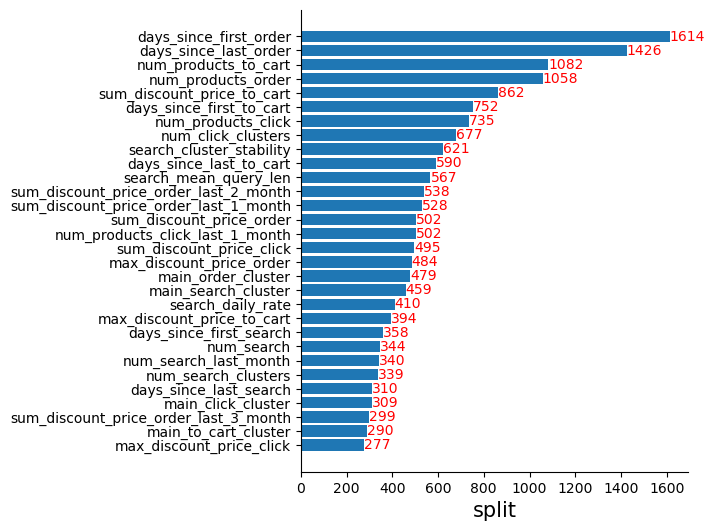

In [15]:
print('feature_importance:', model.feature_importances_, '\n')
plot_lgbm_importance(model, cols, importance_type='split', top_k=30, sklearn_style=True)

# ==================== TEST DATA ====================
test_users_submission = pl.read_csv(os.path.join(data_path, 'test_users.csv'))

In [16]:
t = model.booster_.trees_to_dataframe()
t

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S2,0-S1,None,days_since_last_order,246002.000000,40.5,<=,right,NaN,-0.640010,296684.000000,1312468
1,0,2,0-S2,0-S5,0-S3,0-S0,sum_discount_price_to_cart,18489.099609,10651.5,<=,left,NaN,-0.623179,67175.000000,297168
2,0,3,0-S5,0-S11,0-S10,0-S2,sum_discount_price_order_last_3_month,2203.969971,2269.5,<=,left,NaN,-0.628889,30748.300000,136024
3,0,4,0-S11,0-S25,0-S22,0-S5,sum_discount_price_to_cart,654.392029,2449.5,<=,left,NaN,-0.630920,19519.500000,86350
4,0,5,0-S25,0-L0,0-S28,0-S11,num_products_order,243.102005,1.5,<=,left,NaN,-0.632699,10039.400000,44412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42634,698,3,698-S2,698-S3,698-L3,698-S1,main_favorite_cluster,12.805500,3.5,<=,right,NaN,-0.000622,1055.050000,6370
42635,698,4,698-S3,698-L2,698-L4,698-S2,sum_discount_price_favorite,31.135401,1107.5,<=,left,NaN,0.012036,7.932760,57
42636,698,5,698-L2,None,None,698-S3,None,NaN,NaN,None,None,None,-0.001053,5.522277,37
42637,698,5,698-L4,None,None,698-S3,None,NaN,NaN,None,None,None,0.042022,2.410483,20


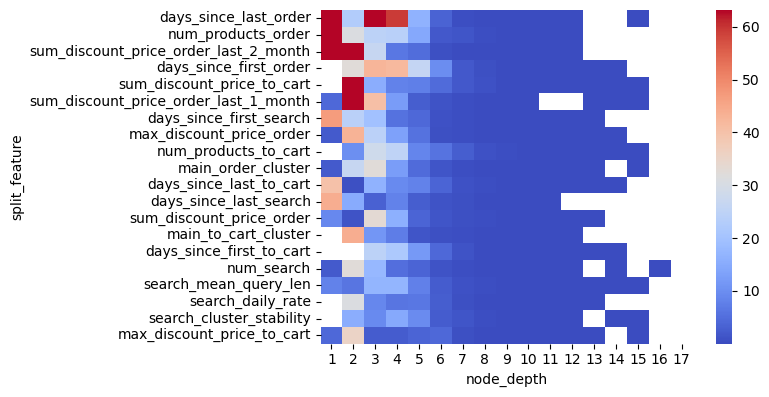

In [17]:
from warnings import filterwarnings
filterwarnings('ignore')

plot_feature_depth(t, top_k=20)

In [18]:
import joblib
joblib.dump(model, 'lgb_model.pkl') 

model.booster_.save_model('lgb_model_booster.txt')

In [ ]:
actions_aggs_test, combined_test, _ = get_actions_aggs(
    actions_history, product_information, val_end_date, test_start_date
)

search_aggs_test = get_search_aggs(
    search_history, val_end_date, test_start_date
)

# Построение финального датафрейма для теста
df_main_test = build_features(test_users_submission, actions_aggs_test, search_aggs_test)
df_pd_test = df_main_test.to_pandas()

# Добавление полиномиальных признаков
#df_pd_test = add_polynomial_features_pd(df_pd_test, num_cols, degree=2)

# Предсказание
df_pd_test['predict'] = model.predict_proba(df_pd_test[cols])[:, 1]

In [ ]:
df_pd_test[['user_id', 'predict']]

,user_id,predict
0,1342,0.171022
1,9852,0.754665
2,10206,0.221263
3,11317,0.228049
4,13289,0.582436
...,...,...
2068419,11157283,0.198865
2068420,11160395,0.141475
2068421,11165052,0.589538
2068422,11168218,0.429482


In [ ]:
df_pd_test[['user_id', 'predict']].to_csv('adv_cluster_res.csv', index=False)

feature_importance: [ 495   47  484  212  502  148  344 1614   84  590  752   61   93  168
  138  479  502   32 1082   41  862   76 1058  102  538  277   93  199
 1426  459  290    0  339  677  277  410   26  259  528  176  310  252
  309  152  394  340  567  106  299  621  358  164  735  250  173] 



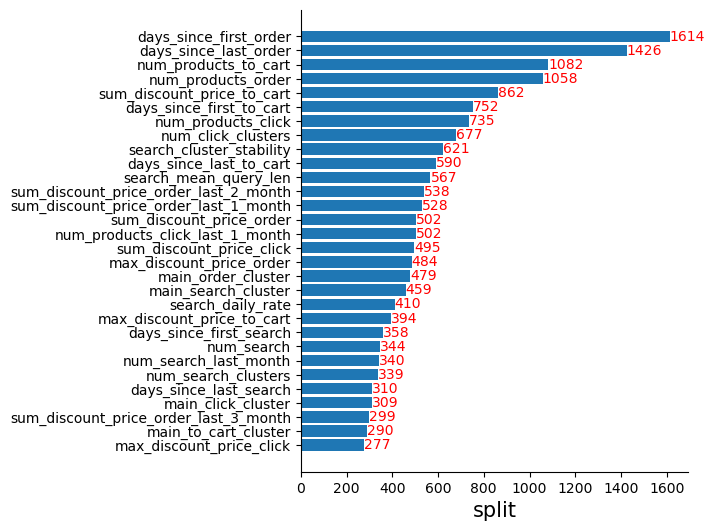

In [20]:
print('feature_importance:', model.feature_importances_, '\n')
plot_lgbm_importance(model, cols, importance_type='split', top_k=30, sklearn_style=True)

# ==================== TEST DATA ====================
test_users_submission = pl.read_csv(os.path.join(data_path, 'test_users.csv'))

In [55]:
plot_scores(model, tr[cols], tr.target, val[cols], val.target)

KeyboardInterrupt: 

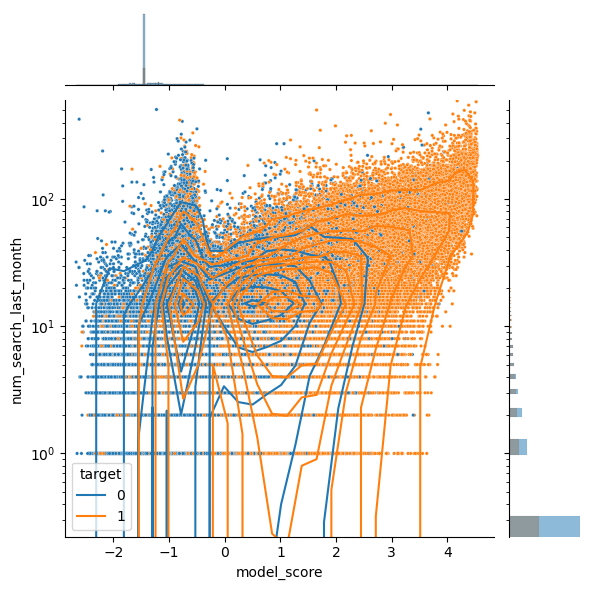

In [54]:
plot_scores(model, tr[cols], tr.target, val[cols], val.target, support_col='num_search_last_month', support_log=True)